# Graph Neural Networks – Instructional Notebook

This notebook mirrors the lecture overview of Graph Neural Networks (GNNs).  


## Learning Goals

By the end of this notebook, you should be able to:

- Represent a simple graph in code (nodes, edges, features).
- Explain the **message passing** view of GNNs.
- Implement a **single GCN-style layer** from scratch.
- Train a small **GCN model on citation data** (e.g., Cora) using PyTorch Geometric.
- Interpret the difference between **node features**, **adjacency**, and **learned embeddings**.


---
## Part 0 – Environment Setup

If you are running this on your own machine, you will need:

- Python 3.9+
- `torch` (PyTorch)
- `torch_geometric` and its dependencies
- `networkx` and `matplotlib` for simple visualization (optional but helpful)

### Suggested installation (in a fresh environment)

> ⚠️ Run these *one cell at a time* in a terminal or notebook.  
> On some platforms you may need to adjust the installation commands.


In [34]:
# Uncomment and run if needed. These commands may vary by platform.
# !pip install torch --index-url https://download.pytorch.org/whl/cpu
# or: follow instructions at https://pytorch.org/get-started/locally/

# PyTorch Geometric (CPU version example); see official docs for CUDA variants:
# !pip install torch-geometric

# Optional utilities:
# !pip install networkx matplotlib


---
## Part 1 – A Tiny Graph 

We start with a very small graph to make the computations transparent.

We will:

1. Define a graph with 5 nodes and undirected edges.
2. Give each node a simple scalar feature.


In [35]:
import torch

# 5 nodes (display labels 1..5; internal indices 0..4)
num_nodes = 5

# Adjacency matrix for an undirected graph (5 nodes)
# Rows/cols: displayed as 1..5 (internal indices 0..4) - symmetric for undirected edges
A = torch.tensor([
    [0, 1, 0, 1, 0],
    [1, 0, 1, 1, 1],
    [0, 1, 0, 0, 0],
    [1, 1, 0, 0, 0],
    [0, 1, 0, 0, 0],
], dtype=torch.float32)

print("Adjacency A shape:", A.shape)
print("Adjacency A: ", A)

# Node features: h^0 \in R^{5 x 1}
h0 = torch.tensor([[1.0],
                   [2.0],
                   [3.0],
                   [4.0],
                   [5.0]])

print("Initial node features h0: ", h0)


Adjacency A shape: torch.Size([5, 5])
Adjacency A:  tensor([[0., 1., 0., 1., 0.],
        [1., 0., 1., 1., 1.],
        [0., 1., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]])
Initial node features h0:  tensor([[1.],
        [2.],
        [3.],
        [4.],
        [5.]])


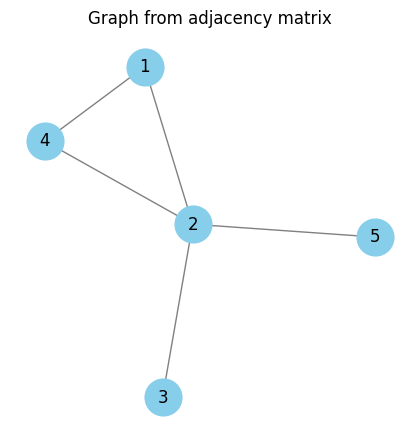

In [36]:
# Visualize the graph defined by adjacency matrix A
try:
    import networkx as nx
    import matplotlib.pyplot as plt
except ImportError as e:
    print("Missing package. Install with: pip install networkx matplotlib")
    raise e

# Make sure A is a numpy array for networkx convenience
A_np = A.numpy() if hasattr(A, 'numpy') else A
G = nx.from_numpy_array(A_np)
# Layout and plotting
pos = nx.spring_layout(G, seed=42)
plt.figure(figsize=(4, 4))
# Label nodes 1..5 instead of 0..4 for display
labels = {n: str(n+1) for n in G.nodes()}
nx.draw(G, pos=pos, labels=labels, node_color='skyblue', node_size=700, edge_color='gray')
plt.title('Graph from adjacency matrix')
plt.show()

---
## Part 2 – Message Passing by Hand

We start with a very small graph to make the computations transparent.

We will:

- Perform one **message passing** step using:  
   $m_{u \rightarrow v} = h_u$ and $h_v' = \text{mean}_{u \in \mathcal{N}(v) \cup \{v\}} m_{u \rightarrow v}$.


In [37]:
def mean_aggregate(h, A):
    """Single message passing step with mean aggregation.
    
    For each node v:
      - collect features from neighbors u (via adjacency matrix A)
      - include v itself
      - compute mean
    """
    # Use matrix operations with A (include self-loops via I)
    A_hat = A + torch.eye(A.size(0))
    deg = A_hat.sum(dim=1, keepdim=True)
    # Sum neighbor features via matrix multiply, then divide by degree -> mean
    out = (A_hat @ h) / deg
    return out

h1 = mean_aggregate(h0, A)
print("Updated node features h1 after one message passing step:", h1)


Updated node features h1 after one message passing step: tensor([[2.3333],
        [3.0000],
        [2.5000],
        [2.3333],
        [3.5000]])


**Discussion prompts:**

- How did each node's value change?
- Which nodes have more similar features after one step? Why?
- What happens if you apply multiple steps of this mean aggregation?  
  (Try calling `mean_aggregate` again on `h1`.)

> This is the **core idea** of GNNs: nodes repeatedly **aggregate** neighbor information.


---
## Part 3 – A Simple GCN Layer from Scratch

Now we implement a single **GCN-style layer** for the whole graph using matrices.

The theoretical formula (Kipf & Welling, 2017) is:

$
H^{(k+1)} = \sigma\left( \tilde{D}^{-1/2} \tilde{A} \tilde{D}^{-1/2} H^{(k)} W^{(k)} \right)
$

where:

- $\tilde{A} = A + I$ adds self-loops.
- $ \tilde{D} $ is the degree matrix of $ \tilde{A} $.
- $ H^{(k)} $ is the matrix of node features.
- $ W^{(k)} $ is a learnable weight matrix.


In [38]:
import torch

# Reuse num_nodes = 5 from before
# Use the adjacency matrix A from Part 1 (already defined)
print("Adjacency A\n", A)

# Add self-loops: A_tilde = A + I
I = torch.eye(num_nodes)
A_tilde = A + I

# Degree matrix D_tilde
deg = A_tilde.sum(dim=1)
D_tilde_inv_sqrt = torch.diag(torch.pow(deg, -0.5))

print("Degree vector:", deg)


Adjacency A
 tensor([[0., 1., 0., 1., 0.],
        [1., 0., 1., 1., 1.],
        [0., 1., 0., 0., 0.],
        [1., 1., 0., 0., 0.],
        [0., 1., 0., 0., 0.]])
Degree vector: tensor([3., 5., 2., 3., 2.])


In [39]:
def gcn_layer(H, A_tilde, D_tilde_inv_sqrt, W):
    """Single GCN layer: H' = D^{-1/2} A D^{-1/2} H W"""
    H_hat = D_tilde_inv_sqrt @ A_tilde @ D_tilde_inv_sqrt @ H
    return H_hat @ W

# Example: input features H0 (5 nodes, 2 features)
H0 = torch.tensor([[1.0, 0.5],
                   [2.0, -1.0],
                   [0.0, 1.0],
                   [3.0, 2.0],
                   [4.0, 0.0]])

# Weight matrix W: 2 -> 2
W = torch.tensor([[1.0, 0.0],
                  [0.0, 1.0]], requires_grad=True)

H1 = gcn_layer(H0, A_tilde, D_tilde_inv_sqrt, W)
print("H1 (GCN output before nonlinearity):\n", H1)


H1 (GCN output before nonlinearity):
 tensor([[ 1.8497,  0.5751],
        [ 2.6977,  0.7617],
        [ 0.6325,  0.1838],
        [ 1.8497,  0.5751],
        [ 2.6325, -0.3162]], grad_fn=<MmBackward0>)


Try:

- Changing `H0` to different values.
- Changing `W` (e.g., random initialization with `torch.randn`).
- Applying a nonlinearity, e.g., `torch.relu(H1)`.  

This is a **hand-built GCN layer** equivalent in spirit to what high-level libraries provide.


---
## Part 4 – Node Classification on Cora with PyTorch Geometric

Now we use **PyTorch Geometric (PyG)** to train a small GCN on the Cora citation network.

We will:

1. Load the Cora dataset.
2. Define a 2-layer GCN model using `GCNConv`.
3. Train for a few epochs.
4. Evaluate node classification accuracy.


In [40]:
import torch
from torch import nn
from torch.nn import functional as F

try:
    from torch_geometric.datasets import Planetoid
    from torch_geometric.nn import GCNConv
except ImportError as e:
    print("PyTorch Geometric is not installed. Please install it first.")
    raise e


In [41]:
# Load Cora (will download on first run)
dataset = Planetoid(root="data/Cora", name="Cora")
data = dataset[0]

print(data)
print("Number of nodes:", data.num_nodes)
print("Number of edges:", data.num_edges)
print("Number of features:", dataset.num_node_features)
print("Number of classes:", dataset.num_classes)


Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708])
Number of nodes: 2708
Number of edges: 10556
Number of features: 1433
Number of classes: 7


In [ ]:
class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        self.dropout = dropout

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.conv3(x, edge_index)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GCN(dataset.num_node_features, 32, dataset.num_classes).to(device)
data = data.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)


In [43]:
def train_epoch():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.cross_entropy(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)

    accs = {}
    for split, mask in [("train", data.train_mask),
                        ("val", data.val_mask),
                        ("test", data.test_mask)]:
        correct = (pred[mask] == data.y[mask]).sum()
        acc = int(correct) / int(mask.sum())
        accs[split] = acc
    return accs

for epoch in range(1, 2001):
    loss = train_epoch()
    if epoch % 10 == 0:
        accs = test()
        print(f"Epoch {epoch:03d} | Loss: {loss:.4f} | "
              f"Train: {accs['train']:.3f} | Val: {accs['val']:.3f} | Test: {accs['test']:.3f}")


Epoch 010 | Loss: 0.5081 | Train: 0.993 | Val: 0.772 | Test: 0.781
Epoch 020 | Loss: 0.0705 | Train: 1.000 | Val: 0.756 | Test: 0.781
Epoch 030 | Loss: 0.0226 | Train: 1.000 | Val: 0.774 | Test: 0.787
Epoch 040 | Loss: 0.0208 | Train: 1.000 | Val: 0.764 | Test: 0.789
Epoch 050 | Loss: 0.0169 | Train: 1.000 | Val: 0.774 | Test: 0.795
Epoch 060 | Loss: 0.0191 | Train: 1.000 | Val: 0.770 | Test: 0.802
Epoch 070 | Loss: 0.0221 | Train: 1.000 | Val: 0.784 | Test: 0.803
Epoch 080 | Loss: 0.0216 | Train: 1.000 | Val: 0.776 | Test: 0.804
Epoch 050 | Loss: 0.0169 | Train: 1.000 | Val: 0.774 | Test: 0.795
Epoch 060 | Loss: 0.0191 | Train: 1.000 | Val: 0.770 | Test: 0.802
Epoch 070 | Loss: 0.0221 | Train: 1.000 | Val: 0.784 | Test: 0.803
Epoch 080 | Loss: 0.0216 | Train: 1.000 | Val: 0.776 | Test: 0.804
Epoch 090 | Loss: 0.0194 | Train: 1.000 | Val: 0.778 | Test: 0.800
Epoch 100 | Loss: 0.0162 | Train: 1.000 | Val: 0.780 | Test: 0.800
Epoch 110 | Loss: 0.0224 | Train: 1.000 | Val: 0.778 | Test: 0

**Discussion prompts:**

- Why do we use different masks (`train_mask`, `val_mask`, `test_mask`) on the same graph?
- Where is the message passing happening in this model?
- How does this implementation relate to the matrix form from Part 2?


---
## Part 5 – Visualizing Node Embeddings

We can project the learned node embeddings to 2D (e.g., via t-SNE or PCA) and color them by class.

This is optional but can give students a concrete feel for “embedding space”.


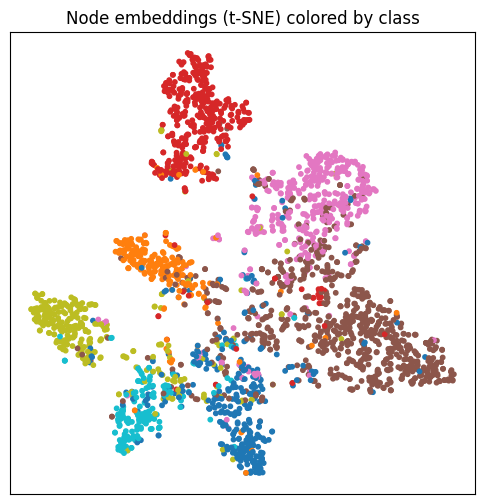

In [44]:
# !pip install matplotlib scikit-learn

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    embeddings = out.cpu()

tsne = TSNE(n_components=2, init='pca', learning_rate='auto')
emb_2d = tsne.fit_transform(embeddings)

y = data.y.cpu()

plt.figure(figsize=(6, 6))
scatter = plt.scatter(emb_2d[:, 0], emb_2d[:, 1], c=y, s=10, cmap="tab10")
plt.title("Node embeddings (t-SNE) colored by class")
plt.xticks([])
plt.yticks([])
plt.show()


---
## Part 6 – Wrap-Up and Reflection

Answer these questions:

1. In your own words, describe **message passing** in a GNN.
2. How does the **GCN layer** avoid simply summing neighbor features?
3. Why do deeper GNNs sometimes suffer from **over-smoothing**?
4. For a new application (e.g., traffic prediction on a road network), what would you choose as:
   - Node features?
   - Edge features?
   - Target prediction task (node, edge, or graph)?